

### Catarina Silva (June 2022)

This pipeline uses a TF-Hub module trained to perform object detection.

## Setup


In [1]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# For reading images
import cv2


# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.8.2
The following GPU devices are available: /device:GPU:0


# Mount and import dataset from Google Cloud Platform (GCP)

In [ ]:
ls

sample_data/


In [ ]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()


In [ ]:
BUCKET_NAME = 'bucket_name'

GCS_BUCKET = f'gs://{BUCKET_NAME}'
!gsutil mb -p $GCP_PROJECT_ID $GCS_BUCKET

CommandException: Incorrect option(s) specified. Usage:

  gsutil mb [-b (on|off)] [-c <class>] [-k <key>] [-l <location>] [-p <project>]
            [--autoclass] [--retention <time>] [--pap <setting>]
            [--placement <region1>,<region2>]
            [--rpo (ASYNC_TURBO|DEFAULT)] gs://<bucket_name>...

For additional help run:
  gsutil help mb


In [ ]:
# !pip install gcloud

In [ ]:
# install gcsfuse on colab.
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
OK
94 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 94 not upgraded.
Need to get 12.0 MB of archives.
After this operation, 28.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.40.0_amd64.deb ...
Unpacking gcsfuse (0.40.0) ...
Setting up gcsfuse (0.40.0) ...


In [ ]:
!mkdir deeper_data
!gcsfuse --implicit-dirs fish_size_project_data deeper_data


2022/04/05 12:39:15.242257 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/deeper_data
2022/04/05 12:39:15.254505 Opening GCS connection...
2022/04/05 12:39:15.541352 Mounting file system "fish_size_project_data"...
2022/04/05 12:39:15.573097 File system has been successfully mounted.


# Dataset for demonstration

## Download and mount the dataset from Github

In [2]:
import os
git_folder = "fishsizeproject/ML-framework-for-image-processing"
if os.path.exists(git_folder) == False:
   !git clone https://github.com/fishsizeproject/ML-framework-for-image-processing.git

path_to_images = git_folder + "/step3_pre-annotations/"

Cloning into 'object_detection_pre-annotation'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66
Unpacking objects: 100% (66/66), done.


In [14]:
cd ./step3_pre-annotations/

/content/object_detection_pre-annotation/images


In [37]:
image1 = 'brian-yurasits-891v7kZMSMg-unsplash.jpg'
image2 = 'geoffrey-smith-YXmpFbSF6Dw-unsplash.jpg'

# Apply module


Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [6]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Define functions

In [35]:
# Copyright 2018 The TensorFlow Hub Authors.

# Licensed under the Apache License, Version 2.0 (the "License");

import numpy as np

from keras.preprocessing import image


def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=10,
                               display_str_list=(),
                               use_normalized_coordinates=False):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
    
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)


  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.8x.
  total_display_str_height = (1 + 2 * 0.8) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=1, min_score=0.7):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              88)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin - 0.03,
          xmin - 0.03,
          ymax + 0.03,
          xmax + 0.03,
          color,
          font,
          display_str_list=[display_str],
          use_normalized_coordinates=False)
      np.copyto(image, np.array(image_pil))

  return image

In [8]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [9]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)
  print("Top detection box:", result["detection_boxes"][:1,:])
  print("Top detection class entity:", result["detection_class_entities"][:1])
  print("Top detection score:", result["detection_scores"][:1])

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  
  display_image(image_with_boxes)


# Run detector in individual images

Found 100 objects.
Inference time:  1.5333991050720215
Top detection box: [[0.23478481 0.19169322 0.78184426 0.9513218 ]]
Top detection class entity: [b'Fish']
Top detection score: [0.9850663]


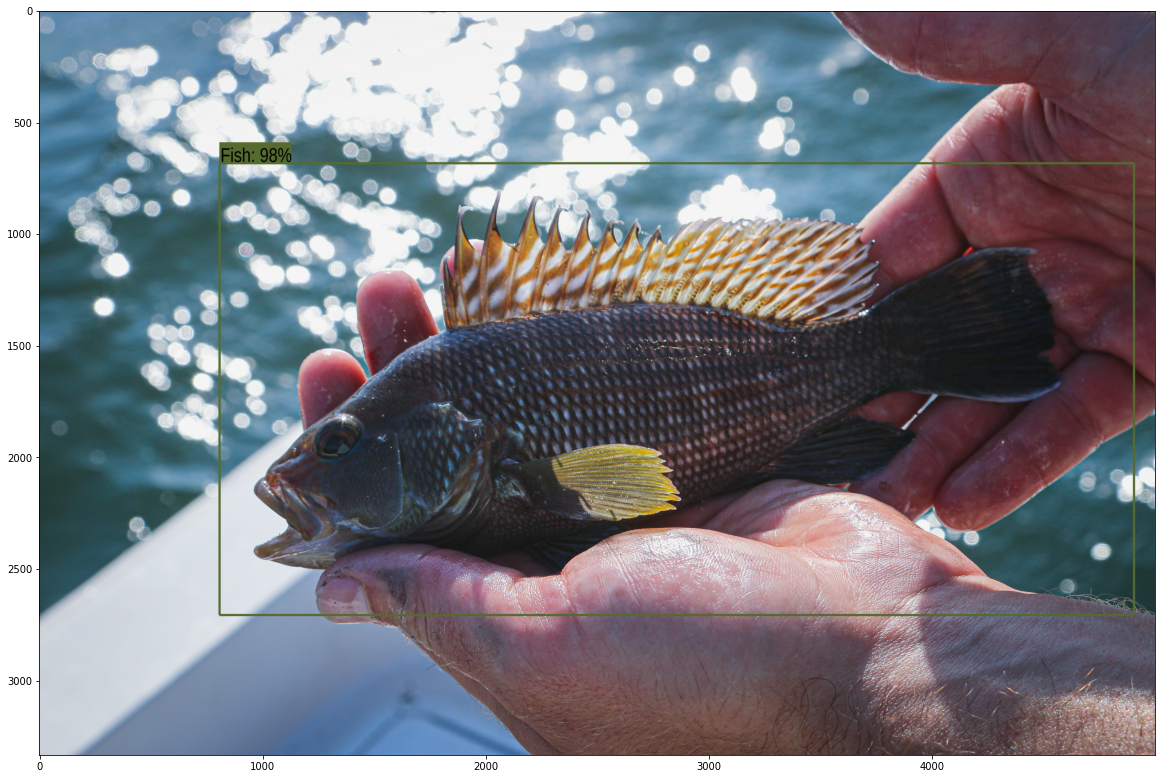

In [36]:
run_detector(detector, image1)

Found 100 objects.
Inference time:  1.460526466369629
Top detection box: [[0.48497093 0.54089236 0.9191727  0.8393128 ]]
Top detection class entity: [b'Fish']
Top detection score: [0.76044667]


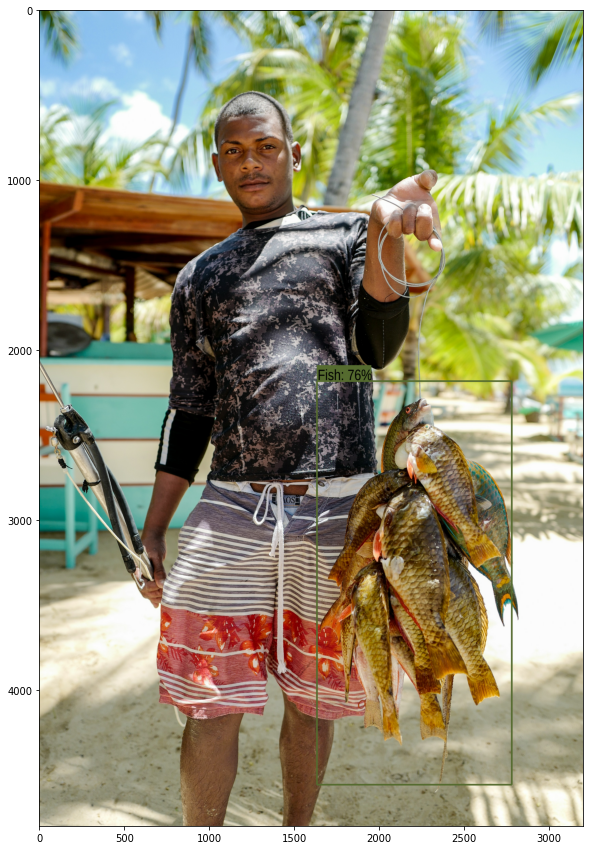

In [38]:
run_detector(detector, image2)

In [ ]:
# import glob
# images = [cv2.imread(file) for file in glob.glob("images/*.png")]


## Save bounding box metadata

In [ ]:
ls

adc.json  deeper_data/  sample_data/


In [ ]:
!mkdir deeper_data_bboxes

### Convert to absolute coordinates

In [ ]:
  img = load_img(image1)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)
  print("Top detection box:", result["detection_boxes"][:1,:])
  print("Top detection class entity:", result["detection_class_entities"][:1])
  print("Top detection score:", result["detection_scores"][:1])
  # print(xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)


Found 100 objects.
Inference time:  51.371073722839355
Top detection box: [[0.3661643  0.07296658 0.9471287  0.96998286]]
Top detection class entity: [b'Fish']
Top detection score: [0.9491231]


In [ ]:
image_h = img.shape[0:1]
image_h

TensorShape([960])

In [ ]:
image_w = img.shape[1:2]
image_w

TensorShape([1280])

In [ ]:
# x, y values for csv format
xmin_absolute = result["detection_boxes"][0:1,1:2] * image_w
xmin_absolute

array([[93.3972168]])

In [ ]:
ymin_absolute = result["detection_boxes"][0:1,0:1] * image_h
ymin_absolute

array([[351.51772499]])

In [ ]:
xmax_absolute = result["detection_boxes"][0:1,3:4] * image_w
xmax_absolute

array([[1241.57806396]])

In [ ]:
ymax_absolute = result["detection_boxes"][0:1,2:3] * image_h
ymax_absolute

array([[909.24356461]])

In [ ]:
xmin_absolute, ymin_absolute, bbox_w, bbox_h = (xmin_absolute, ymin_absolute,
     (xmax_absolute - xmin_absolute),
     (ymax_absolute - ymin_absolute)
     )

xmin_absolute, ymin_absolute, bbox_w, bbox_h

(array([[93.3972168]]),
 array([[351.51772499]]),
 array([[1148.18084717]]),
 array([[557.72583961]]))

In [ ]:
# image size
import os
image1_size = os.path.getsize(image1)
image1_size

2037305

### csv file in VGG format

In [ ]:
image_path, image_name = os.path.split(image1)

print(image_name)


00007cc1-fbe2-411d-acb9-0a5e85652625.png


In [ ]:
name = '{"name":"rect","x":' 
xmin = xmin_absolute.item()
y = ',"y":'
ymin = ymin_absolute.item()
w = ',"width":'
width =  bbox_w.item()
h = ',"height":'
height = bbox_h.item()
end = '}'

region_shape_attributes = f'{name} {xmin} {y} {ymin} {w} {width} {h} {height} {end}'

region_shape_attributes

'{"name":"rect","x": 93.397216796875 ,"y": 351.5177249908447 ,"width": 1148.1808471679688 ,"height": 557.7258396148682 }'

In [ ]:
import csv

header = ['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']
# region_shape_attributes =  "{''name'':''rect'',''x'':'", xmin_absolute.item(), ",''y'':", ymin_absolute.item(), ",''width'':", bbox_w.item(), ",''height'':", bbox_h.item(), "}"


attributes = {"fish":"fish"}
data = [image_name, image1_size, "{}", 1, 0, region_shape_attributes, "{}"]


with open('annotations_VGG.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerow(data)


# Run detector on several images

In [ ]:
import os

# Print current working directory
print("Current working dir : %s" % os.getcwd())


Current working dir : /content


In [ ]:
import os
import csv

# search for files in 'images' dir
files_dir = os.getcwd() + '/deeper_data/MonthlyDeeperData/2021-12-01/images'
files = os.listdir(files_dir)

# loop over files, print prediction if it is an image
for f in files:
  if f.lower().endswith(('.png')):
    images_path = files_dir + '/' + f
    
  # run_detector()
    img = load_img(images_path)
      
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)
    print("Top detection box:", result["detection_boxes"][:1,:])
    print("Top detection class entity:", result["detection_class_entities"][:1])
    print("Top detection score:", result["detection_scores"][:1])

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])
  
      # display_image(image_with_boxes)

      # convert to absolute coordinates
    image_h = img.shape[0:1]
      
    image_w = img.shape[1:2]
      
    xmin_absolute = result["detection_boxes"][0:1,1:2] * image_w
    xmax_absolute = result["detection_boxes"][0:1,3:4] * image_w
    ymin_absolute = result["detection_boxes"][0:1,0:1] * image_h
    ymax_absolute = result["detection_boxes"][0:1,2:3] * image_h

    xmin_absolute, ymin_absolute, bbox_w, bbox_h = (xmin_absolute, ymin_absolute,
                                                    (xmax_absolute - xmin_absolute),
                                                    (ymax_absolute - ymin_absolute))

    xmin_absolute, ymin_absolute, bbox_w, bbox_h

    image_size = os.path.getsize(images_path)
    image_path, image_name = os.path.split(images_path)

    # format values for region shape attributes
    name = '{"name":"rect","x":' 
    xmin = xmin_absolute.item()
    y = ',"y":'
    ymin = ymin_absolute.item()
    w = ',"width":'
    width =  bbox_w.item()
    h = ',"height":'
    height = bbox_h.item()
    end = '}'

    image_region_shape_attributes = f'{name} {xmin} {y} {ymin} {w} {width} {h} {height} {end}'
    image_attributes = '{}'
    image_region_count = '1'
    image_region_id = '0'
    image_region_attributes = '{}'
    inference = end_time-start_time

    # save csv file 
    with open('annotations_VGG_2021-12-01.csv', 'a') as csvfile:
      # csvfile.write(f'filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes\n')
      fieldnames = ['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']
      print(fieldnames)
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      print(writer)
      writer.writerow({'filename':image_name, 'file_size':image_size, 'file_attributes':image_attributes, 'region_count':image_region_count, 'region_id':image_region_id, 'region_shape_attributes':image_region_shape_attributes, 'region_attributes':image_region_attributes,})

      
  # save csv file 
    with open('inference_times_2021-12-01.csv', 'a') as csvfile2:
      fieldnames2 = ['filename', 'inference_time']
      print(fieldnames2)
      writer = csv.DictWriter(csvfile2, fieldnames=fieldnames2)
      print(writer)
      writer.writerow({'filename':image_name, 'inference_time':inference})
              
        

Streaming output truncated to the last 5000 lines.
Top detection score: [0.8961226]
['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']
['filename', 'inference_time']
Found 100 objects.
Inference time:  30.23266077041626
Top detection box: [[0.21024038 0.09774448 0.6136787  0.7099214 ]]
Top detection class entity: [b'Fish']
Top detection score: [0.90869176]
['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']
['filename', 'inference_time']
Found 100 objects.
Inference time:  30.132176160812378
Top detection box: [[0.6262925  0.00859268 0.9858466  0.86337566]]
Top detection class entity: [b'Fish']
Top detection score: [0.7320165]
['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']
['filename', 'inference_time']
Found 100 objects.
Inference time:  27.91328263282776
Top detection box